In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op
import corner
import scipy

In [2]:
c=cte.c
c_um=c.to("um/s")
c_mm=c.to("mm/s")
Msun=cte.M_sun

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/SPT.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

z=[]

S3=[]
errS3=[]

S2=[]
errS2=[]

S1=[]
errS1=[]

S870=[]
errS870=[]

S500=[]
errS500=[]

S350=[]
errS350=[]

S250=[]
errS250=[]

S160=[]
errS160=[]

S100=[]
errS100=[]

for j in rows:   
    
    ID.append(j[0])
    z.append(float(j[1]))
    S3.append(float(j[2]))
    errS3.append(float(j[3]))
    S2.append(float(j[4]))
    errS2.append(float(j[5]))
    S1.append(float(j[6]))
    errS1.append(float(j[7]))
    S870.append(float(j[8]))
    errS870.append(float(j[9]))
    S500.append(float(j[10]))
    errS500.append(float(j[11]))
    S350.append(float(j[12]))
    errS350.append(float(j[13]))
    S250.append(float(j[14]))
    errS250.append(float(j[15]))
    S160.append(float(j[16]))
    errS160.append(float(j[17]))
    S100.append(float(j[18]))
    errS100.append(float(j[19]))
   

In [4]:
v__=np.array([870,500,350,250,160,100])*un.um
v_=(c_um/v__).to("Hz")
v=v_.value
l__=np.array([3.2,2,1.4])*un.mm
l_=(c_mm/l__).to("Hz")
l=l_.value
vf=np.concatenate((l,v))
print(vf)

[9.36851431e+10 1.49896229e+11 2.14137470e+11 3.44589032e+11
 5.99584916e+11 8.56549880e+11 1.19916983e+12 1.87370286e+12
 2.99792458e+12]


In [5]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [6]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [7]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.e**-TAU)*PL
    S=S_.to("mJy")
    return S.value

In [8]:
def A(z,Tc,M_,d_,vf): 


    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [9]:
def modelSobs(vf,z,Tc,M_,d_): #Como SPT no entrega Tc tomamos Tc= T-10]
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    
    INTEGRAL=A(z,Tc,M_,d_,vf)
    TAU=tau(z,M_,d_,vf)
    
    h=cte.h
    K=cte.k_B
    vf=vf*un.Hz
    d_=d_*un.kpc
    Tc=Tc*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * INTEGRAL[j]
    
        M2=O * np.e**-TAU * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append(((M1+M2)[0]).value)
        
    model=model_*un.mJy

    return model.value

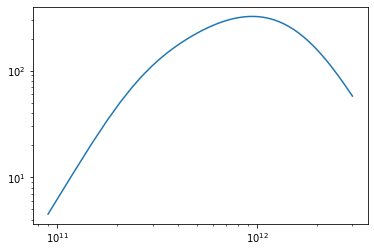

In [10]:
x = np.linspace(90,3000,100)*un.GHz
x = x.to("Hz")
x = x.value

plt.plot(x,modelSobs(x,3.,50.,10.,4.))
plt.xscale("log")
plt.yscale("log")

In [11]:
frecs0T = np.array([S3[0],S2[0],S1[0],S870[0],S500[0],S350[0],S250[0],S160[0],S100[0]])

In [12]:
errf0T = np.array([errS3[0],errS2[0],errS1[0],errS870[0],errS500[0],errS350[0],errS250[0],errS160[0],errS100[0]])

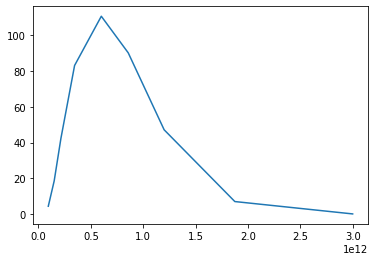

In [13]:
plt.plot(vf,modelSv(vf,4.,50.,10.,4.))

In [14]:
popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecs0T,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))

In [15]:
z_fit,T_fit,M_fit,d_fit = popt

In [16]:
popt

array([ 2.01924471, 62.50486116,  9.31630607,  2.78576338])

In [17]:
def ml_S(ID,frecsT): #Single
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    plt.figure(figsize=(12,9))

    pm = [z_fit,T_fit,M_fit,d_fit]

    y = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

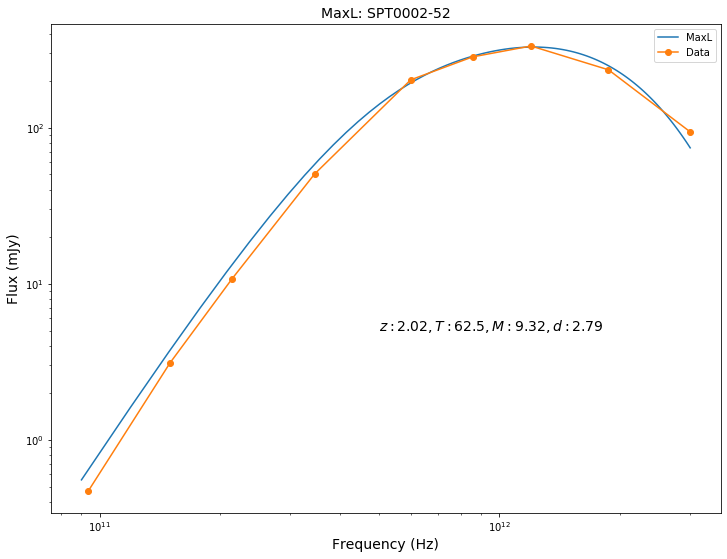

In [18]:
ml_S(ID[0],frecs0T)

In [19]:
def ml_PL(ID,frecsT): #PL
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,47.,10.,4.],bounds=([1,10,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    popt
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

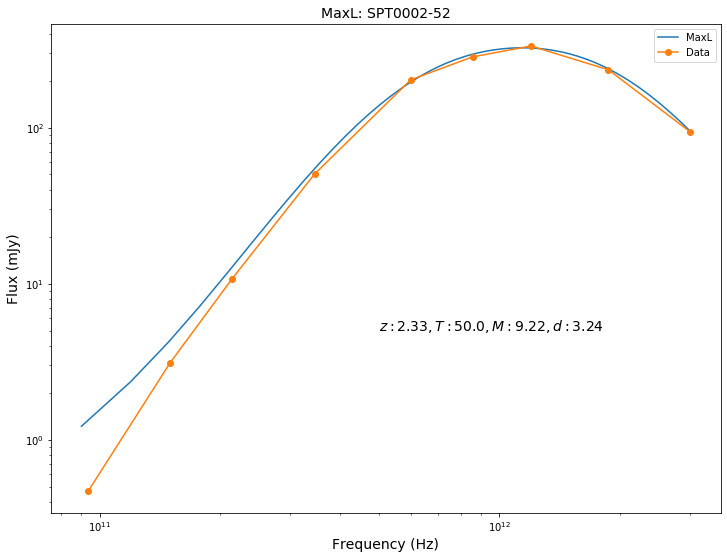

In [20]:
ml_PL(ID[0],frecs0T)

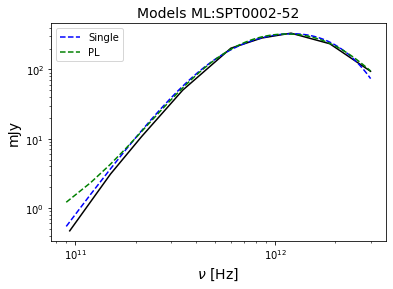

In [21]:
plt.plot(vf,frecs0T,"k")
plt.plot(x,modelSv(x,2.02,62.5,9.31,2.78),ls="--",c="b",label="Single") #parametros de ML para S
plt.plot(x,modelSobs(x,2.33,50.,9.22,3.24),ls="--",c="g",label="PL") #parametros de ML para PL
plt.xscale("log")
plt.yscale("log")
plt.title("Models ML:{}".format(ID[0]),fontsize=14)
plt.xlabel(r"$\nu$ [Hz]",fontsize=14)
plt.ylabel("mJy",fontsize=14)
plt.legend()

El siguiente plot muestra la diferencia entre modelos.

PL-S: [  0.66988108   0.74753446   0.62498578   0.29624292  -0.21310418
  -0.8536758   -1.5587448   -2.25066047  -2.84802134  -3.27354854
  -3.4619481   -3.36673854  -2.96507123  -2.25988979  -1.27922377
  -0.07286447   1.29297005   2.74215919   4.19551675   5.5771467
   6.81970768   7.86821012   8.68221011   9.23647375   9.5203411
   9.53611142   9.29680318   8.8236245    8.14343679   7.28642336
   6.28409877   5.16772528   3.96714582   2.7100022    1.42128191
   0.12312578  -1.16517231  -2.42703624  -3.64840087  -4.81746814
  -5.9244549   -6.96135112  -7.92169945  -8.8004007   -9.59354595
 -10.29827358 -10.91264781 -11.43555542 -11.86661692 -12.20610907
 -12.45489623 -12.61436842 -12.68638454 -12.67321971 -12.57751588
 -12.40223529 -12.15061651 -11.82613271 -11.4324524  -10.97340225
 -10.4529322   -9.87508292  -9.24395536  -8.56368265  -7.83840422
  -7.07224209  -6.26927933  -5.43354066  -4.56897503  -3.67944018
  -2.76868915  -1.84035851  -0.89795829   0.05513643   1.01569245
   1.9

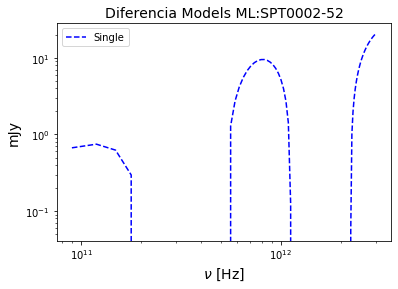

In [22]:
plt.plot(x,modelSobs(x,2.33,50.,9.22,3.24)-modelSv(x,2.02,62.5,9.31,2.78),ls="--",c="b",label="Single")
print("PL-S:",modelSobs(x,2.33,50.,9.22,3.24)-modelSv(x,2.02,62.5,9.31,2.78))
plt.xscale("log")
plt.yscale("log")
plt.title("Diferencia Models ML:{}".format(ID[0]),fontsize=14)
plt.xlabel(r"$\nu$ [Hz]",fontsize=14)
plt.ylabel("mJy",fontsize=14)
plt.legend()